# Economic Narratives Generator: Transforming Economic Data into Readable Insights

## 1. Problem Statement

This project transforms complex economic indicators into approachable natural language narratives for adult wealth managers of all skill levels, using machine learning to classify economic sentiment and GPT-2 to generate readable insights that help individuals make informed financial decisions. 

By combining sentiment classification with GPT-2 text generation, we help even managers without economics expertise understand economic trends and implications.

## 2. Target Audience

**Wealth Managers:** Individuals who are managing US-based financial assets, whether amateurs managing personal finances to professionals managing clients' assets, who want to understand how economic conditions affect US-based lives, jobs, and investments. 

The narratives generated by our economic narratives generator empower them to make informed personal financial decisions by translating complex economic data into clear, actionable insights.

## 3. Setup and Dependencies

In [1]:
# Import necessary libraries for data manipulation, machine learning, and visualization
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Set up visualization style
plt.style.use('fivethirtyeight')

## 4. Data Loading and Preparation

In [3]:
# Load the dataset
try:
    data = pd.read_csv('./data/economic_indicators.csv', parse_dates=['DATE'])
    data.set_index('DATE', inplace=True)
    print(f"Successfully loaded data spanning from {data.index.min().date()} to {data.index.max().date()}")
except FileNotFoundError:
    print('Error: \'./data/economic_indicators.csv\' not found.')
    raise

# Display the first few rows of the dataset
display(data.head())

Successfully loaded data spanning from 1990-01-01 to 2025-04-14


,unemployment,yield_spread,industrial_prod,consumer_conf,LEI,CPI,GDP_Growth,recession_probabilities,fed_funds_rate,currency_strength,housing_starts,personal_consumption_expenses,PPI,SP500
DATE,,,,,,,,,,,,,,
1990-01-01,5.4,NaN,61.6352,93.0,1.71,127.5,10047.386000,0.18,8.23,NaN,1551.0,58.553,114.9,NaN
1990-01-02,5.4,0.07,61.6352,93.0,1.71,127.5,10047.947062,0.18,8.23,NaN,1551.0,58.553,114.9,359.690002
1990-01-03,5.4,0.05,61.6352,93.0,1.71,127.5,10048.508123,0.18,8.23,NaN,1551.0,58.553,114.9,358.760010
1990-01-04,5.4,0.06,61.6352,93.0,1.71,127.5,10049.069185,0.18,8.23,NaN,1551.0,58.553,114.9,355.670013
1990-01-05,5.4,0.09,61.6352,93.0,1.71,127.5,10049.630246,0.18,8.23,NaN,1551.0,58.553,114.9,352.200012


In [4]:
# Select key columns for analysis
key_columns = ['unemployment', 
               'yield_spread', 
               'SP500', 
               'CPI', 
               'recession_probabilities']

# Calculate daily changes for trend analysis
daily_changes = data[key_columns].diff().dropna()
daily_data = data[key_columns].loc[daily_changes.index]

# Combine raw data with change metrics
combined_data = pd.concat([daily_data, daily_changes.add_suffix('_change')], axis=1)

# Display the combined dataset
display(combined_data.head())

,unemployment,yield_spread,SP500,CPI,recession_probabilities,unemployment_change,yield_spread_change,SP500_change,CPI_change,recession_probabilities_change
DATE,,,,,,,,,,
1990-01-03,5.4,0.05,358.760010,127.5,0.18,0.0,-0.02,-0.929993,0.0,0.0
1990-01-04,5.4,0.06,355.670013,127.5,0.18,0.0,0.01,-3.089996,0.0,0.0
1990-01-05,5.4,0.09,352.200012,127.5,0.18,0.0,0.03,-3.470001,0.0,0.0
1990-01-08,5.4,0.12,353.790009,127.5,0.18,0.0,0.03,1.589996,0.0,0.0
1990-01-09,5.4,0.11,349.619995,127.5,0.18,0.0,-0.01,-4.170013,0.0,0.0


## 5. Sentiment Classification Using Machine Learning

We'll use a rule-based approach followed by a Random Forest classifier to determine economic sentiment.

In [5]:
# Define a function to assign economic sentiment based on key indicators
def assign_sentiment(row):
    """
    Assigns economic sentiment based on S&P 500 changes and recession probability changes:
    - Positive: S&P 500 increasing with stable or decreasing recession probability
    - Negative: S&P 500 decreasing or significant increase in recession probability
    - Neutral: All other cases
    """
    if row['SP500_change'] > 0 and row['recession_probabilities_change'] <= 0:
        return 'positive'
    elif row['SP500_change'] < 0 or row['recession_probabilities_change'] > 5:
        return 'negative'
    else:
        return 'neutral'

In [6]:
# Apply sentiment classification to our dataset
combined_data['sentiment'] = combined_data.apply(assign_sentiment, axis=1)

# Visualize the distribution of sentiment values
sentiment_counts = combined_data['sentiment'].value_counts()
print("Sentiment Distribution:")
display(sentiment_counts)

Sentiment Distribution:


sentiment
positive    4678
negative    4139
neutral      508
Name: count, dtype: int64

In [7]:
# Prepare features and target for machine learning
features = [col for col in combined_data.columns if '_change' in col]
X = combined_data[features]
y = combined_data['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model performance
accuracy = rf_model.score(X_test, y_test)
print(f'Sentiment Classifier Accuracy: {accuracy:.2f}')

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(feature_importance)

Sentiment Classifier Accuracy: 1.00

Feature Importance:


,Feature,Importance
2,SP500_change,0.945342
4,recession_probabilities_change,0.025033
3,CPI_change,0.015050
1,yield_spread_change,0.011089
0,unemployment_change,0.003486


## 7. Setting Up GPT-2 for Narrative Generation

We'll use the pre-trained GPT-2 model to generate natural language narratives based on economic data and predicted sentiment.

In [8]:
# Load GPT-2 model and tokenizer
try:
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.eval()
    print("GPT-2 model successfully loaded")
except Exception as e:
    print(f'Error loading GPT-2: {e}')
    raise

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

GPT-2 model successfully loaded


In [9]:
# Load FinBERT model and tokenizer
try:
    finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    print("FinBERT model and tokenizer loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Failed to load FinBERT model: {str(e)}")

FinBERT model and tokenizer loaded successfully.


## 8. Enhanced Narrative Generation Function

This function takes economic data for a specific date, predicts the sentiment, and generates a human-readable narrative using GPT-2.

In [10]:
def generate_narrative_gpt2(date, data, rf_model, finbert_model, finbert_tokenizer, model, tokenizer, max_length=150):
    """
    Generate an economic narrative for a specific date using GPT-2 with combined sentiment voting.
    
    Args:
        date: Target date for narrative
        data: DataFrame containing economic indicators
        rf_model: Trained Random Forest classifier
        finbert_model: FinBERT model for sentiment analysis
        finbert_tokenizer: FinBERT tokenizer
        model: GPT-2 language model
        tokenizer: GPT-2 tokenizer
        max_length: Maximum length of generated text
        
    Returns:
        String containing the economic narrative
    """
    if date not in data.index:
        nearest_idx = data.index.get_indexer([date], method='nearest')[0]
        nearest_date = data.index[nearest_idx]
        return (f'No data available for {date.strftime("%Y-%m-%d")}. '
                f'Nearest available date is {nearest_date.strftime("%Y-%m-%d")}.')
    
    row = data.loc[date]
    date_str = date.strftime('%B %d, %Y')
    
    # Rule-based sentiment
    def assign_sentiment(row):
        if row['SP500_change'] > 0 and row['recession_probabilities_change'] <= 0:
            return 'positive'
        elif row['SP500_change'] < 0 or row['recession_probabilities_change'] > 5:
            return 'negative'
        else:
            return 'neutral'
    rule_sentiment = assign_sentiment(row)
    
    # Random Forest sentiment
    change_cols = [col for col in data.columns if '_change' in col]
    change_data = pd.DataFrame([row[change_cols].values], columns=change_cols)
    rf_sentiment = rf_model.predict(change_data)[0]
    
    # FinBERT sentiment
    summary = (f"On {date_str}, unemployment was {row['unemployment']:.1f}%, "
               f"S&P 500 at {row['SP500']:.2f} ({row['SP500_change']:+.2f} points), "
               f"recession probability at {row['recession_probabilities']:.1f}%, "
               f"yield spread at {row['yield_spread']:.2f}, CPI at {row['CPI']:.1f}.")
    inputs = finbert_tokenizer(summary, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = finbert_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_score = torch.argmax(probs, dim=-1).item()
    finbert_sentiment = ["positive", "neutral", "negative"][sentiment_score]
    
    # Combine sentiments with a voting system
    sentiments = [rule_sentiment, rf_sentiment, finbert_sentiment]
    positive_count = sentiments.count("positive")
    negative_count = sentiments.count("negative")
    neutral_count = sentiments.count("neutral")

    if positive_count > max(negative_count, neutral_count):
        final_sentiment = "positive"
    elif negative_count > max(positive_count, neutral_count):
        final_sentiment = "negative"
    else:
        final_sentiment = "neutral"  # Default to neutral for ties or mixed signals
    
    # Generate narrative based on final sentiment
    sp500_change = row['SP500_change']
    sp500 = row['SP500']
    unemployment = row['unemployment']
    recession_prob = row['recession_probabilities']
    yield_spread = row['yield_spread']
    if final_sentiment == "positive":
        narrative = (f"Economic data for {date_str} points to a positive outlook. The S&P 500 rose by "
                     f"{sp500_change:.2f} points to {sp500:.2f}, reflecting market strength. Unemployment held steady "
                     f"at {unemployment:.1f}%, indicating a robust labor market. With a recession probability of "
                     f"{recession_prob:.1f}% and a yield spread of {yield_spread:.2f}, conditions suggest continued economic stability.")
    elif final_sentiment == "negative":
        narrative = (f"Economic indicators for {date_str} signal caution. The S&P 500 moved by {sp500_change:.2f} "
                     f"points to {sp500:.2f}, with unemployment at {unemployment:.1f}%. A recession probability of {recession_prob:.1f}% "
                     f"and yield spread of {yield_spread:.2f} raise concerns about economic uncertainty.")
    else:
        narrative = (f"On {date_str}, economic conditions appear mixed. The S&P 500 shifted by {sp500_change:.2f} "
                     f"points to {sp500:.2f}, while unemployment remained at {unemployment:.1f}%. A recession probability of "
                     f"{recession_prob:.1f}% and yield spread of {yield_spread:.2f} suggest a wait-and-see approach.")
    
    # Format change values for readability
    sp500_change_str = f"{row['SP500_change']:+.2f}"
    unemp_change_str = f"{row['unemployment_change']:+.2f}"
    recession_change_str = f"{row['recession_probabilities_change']:+.2f}"
    
    # Create prompt for GPT-2
    prompt = (
        f'On {date_str}, economic conditions showed a {final_sentiment} sentiment based on key indicators: '
        f'unemployment stood at {row["unemployment"]:.1f}% (change: {unemp_change_str}%), '
        f'the yield spread was {row["yield_spread"]:.2f} (change: {row["yield_spread_change"]:.2f}), '
        f'the S&P 500 was at {row["SP500"]:.2f} (change: {sp500_change_str} points), '
        f'CPI stood at {row["CPI"]:.1f} (change: {row["CPI_change"]:.2f}), and '
        f'recession probability was {row["recession_probabilities"]:.1f}% '
        f'(change: {recession_change_str}%). '
        'Generate a concise, coherent narrative summarizing these economic conditions.'
    )
    
    # Tokenize prompt
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True)
    
    # Generate narrative with GPT-2
    try:
        with torch.no_grad():
            outputs = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_length + len(inputs['input_ids'][0]),
                num_return_sequences=1,
                do_sample=True,
                top_k=30,
                top_p=0.85,
                temperature=0.5,
                pad_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=2
            )
        
        # Extract only the generated part (not the prompt)
        gpt_narrative = tokenizer.decode(outputs[0], skip_special_tokens=True)
        gpt_narrative = gpt_narrative[len(prompt):].strip()
        
        # Format the final narrative with clear indicator highlights
        formatted_narrative = f"""## Economic Narrative for {date_str}

**Overall Sentiment:** {final_sentiment.upper()}

**Key Indicators:**
- Unemployment: {row['unemployment']:.1f}% ({unemp_change_str}%)
- S&P 500: {row['SP500']:.2f} ({sp500_change_str} points)
- Recession Probability: {row['recession_probabilities']:.1f}% ({recession_change_str}%)
- Yield Spread: {row['yield_spread']:.2f} ({row['yield_spread_change']:.2f})
- CPI: {row['CPI']:.1f} ({row['CPI_change']:.2f})

**Narrative:**
{narrative}

**GPT-2 Enhanced Narrative:**
{gpt_narrative}"""
        
        return formatted_narrative
    except Exception as e:
        return f'Error generating narrative: {e}'

## 9. Generating Sample Narratives

Let's test our narrative generator on several key dates throughout economic history.

In [11]:
# Define sample dates covering different economic periods
sample_dates = [
    pd.to_datetime('1990-01-03'),  # Early 90s
    pd.to_datetime('2008-01-02'),  # Start of 2008 financial crisis
    pd.to_datetime('2019-04-05'),  # Pre-COVID economy
    pd.to_datetime('2020-04-17'),  # COVID economic impact
    pd.to_datetime('2025-04-08'),  # Tariff economic impact
]

# Generate and display narratives for each date
for date in sample_dates:
    narrative = generate_narrative_gpt2(date, combined_data, rf_model, finbert_model, finbert_tokenizer, model, tokenizer)
    display(Markdown(narrative))
    print("\n" + "-"*80 + "\n")

## Economic Narrative for January 03, 1990

**Overall Sentiment:** NEGATIVE

**Key Indicators:**
- Unemployment: 5.4% (+0.00%)
- S&P 500: 358.76 (-0.93 points)
- Recession Probability: 0.2% (+0.00%)
- Yield Spread: 0.05 (-0.02)
- CPI: 127.5 (0.00)

**Narrative:**
Economic indicators for January 03, 1990 signal caution. The S&P 500 moved by -0.93 points to 358.76, with unemployment at 5.4%. A recession probability of 0.2% and yield spread of 0.05 raise concerns about economic uncertainty.

**GPT-2 Enhanced Narrative:**
The following chart provides a summary of the key factors that led to the negative outlook. The chart shows the three main indicators of economic activity: the unemployment rate, the rate of inflation, and the inflation rate. It also shows that the economy's economic growth has been relatively strong. Inflation has increased at a rate that is not as strong as it was in the early 1990s. Since then, inflation has risen at an average rate over the past five years, which is more than double the average of two years ago. This is a sign that economic policy is working. However, it is also a warning that there is still a long way to go. If the economic situation is to improve, policymakers must look at the ways in which


--------------------------------------------------------------------------------



## Economic Narrative for January 02, 2008

**Overall Sentiment:** NEGATIVE

**Key Indicators:**
- Unemployment: 5.0% (+0.00%)
- S&P 500: 1447.16 (-21.20 points)
- Recession Probability: 20.1% (+0.00%)
- Yield Spread: 1.03 (0.04)
- CPI: 212.2 (0.00)

**Narrative:**
Economic indicators for January 02, 2008 signal caution. The S&P 500 moved by -21.20 points to 1447.16, with unemployment at 5.0%. A recession probability of 20.1% and yield spread of 1.03 raise concerns about economic uncertainty.

**GPT-2 Enhanced Narrative:**
The following are the key measures of the economy's economic performance:
. . .
 (1) The S-curve (see Figure 1) shows that the US economy has grown at a rate of 2.9% per year for the past five years. The average annual growth rate is 1% a year. (2) Inflation is the most important indicator of economic growth. It is defined as the amount of money that is spent on goods and services. This is measured as a percentage of GDP. In the United States, the average inflation rate for 2008 was 4.6%. (3) This year, inflation is expected to reach 6.5% and the rate will be revised downward to 6% in the coming


--------------------------------------------------------------------------------



## Economic Narrative for April 05, 2019

**Overall Sentiment:** POSITIVE

**Key Indicators:**
- Unemployment: 3.7% (+0.00%)
- S&P 500: 2892.74 (+13.35 points)
- Recession Probability: 0.6% (+0.00%)
- Yield Spread: 0.15 (-0.03)
- CPI: 255.2 (0.00)

**Narrative:**
Economic data for April 05, 2019 points to a positive outlook. The S&P 500 rose by 13.35 points to 2892.74, reflecting market strength. Unemployment held steady at 3.7%, indicating a robust labor market. With a recession probability of 0.6% and a yield spread of 0.15, conditions suggest continued economic stability.

**GPT-2 Enhanced Narrative:**
The following is a summary of the main indicators of economic growth:
 (1) The SSE's growth rate is up 0% since April. (2) Manufacturing employment is at its lowest level since March. Manufacturing has the highest rate of employment growth since January. The share of manufacturing employment in the economy has increased from 4.1% in April to 5.3% this month. In the manufacturing sector, the share has grown from 3% to 4% over the last 12 months. This is the largest increase in employment since the beginning of 2015. Overall, employment has improved from 2.4% of all employment to 2% and the number of employed has risen from 6.5 million to 6 million. There is also


--------------------------------------------------------------------------------



## Economic Narrative for April 17, 2020

**Overall Sentiment:** POSITIVE

**Key Indicators:**
- Unemployment: 14.8% (+0.00%)
- S&P 500: 2874.56 (+75.01 points)
- Recession Probability: 100.0% (+0.00%)
- Yield Spread: 0.45 (0.04)
- CPI: 256.0 (0.00)

**Narrative:**
Economic data for April 17, 2020 points to a positive outlook. The S&P 500 rose by 75.01 points to 2874.56, reflecting market strength. Unemployment held steady at 14.8%, indicating a robust labor market. With a recession probability of 100.0% and a yield spread of 0.45, conditions suggest continued economic stability.

**GPT-2 Enhanced Narrative:**
The second most important indicator of the economic situation is the number of jobs created. The unemployment rate is a measure of how many people are employed in a given job. It is calculated from the percentage of people who are unemployed in the last year. This is important because it shows that the unemployment rates of those who have been employed for a long time are lower than those of non-employed people. For example, the share of workers who were employed during the year that was nonunemployed was 5.3%, while the proportion of unemployed people was 1.1%.
, and, in contrast to the previous year, there was a significant increase in unemployment in February and March. However, this was not the case for the entire year and


--------------------------------------------------------------------------------



## Economic Narrative for April 08, 2025

**Overall Sentiment:** NEGATIVE

**Key Indicators:**
- Unemployment: 4.2% (+0.00%)
- S&P 500: 4982.77 (-79.48 points)
- Recession Probability: 0.4% (+0.00%)
- Yield Spread: 0.55 (0.13)
- CPI: 319.6 (0.00)

**Narrative:**
Economic indicators for April 08, 2025 signal caution. The S&P 500 moved by -79.48 points to 4982.77, with unemployment at 4.2%. A recession probability of 0.4% and yield spread of 0.55 raise concerns about economic uncertainty.

**GPT-2 Enhanced Narrative:**
The U.S. economy is in a weak position, and the U-turn in the global economy has been a major factor in its recovery. The U.-turn has also been accompanied by a strong dollar, which has weakened the dollar's value relative to the euro. This is a positive sign for the United States, but it is also a sign that the economy will not be able to recover. If the market continues to hold the yen in check, the value of the Japanese yen will drop further. A weak dollar and a weaker dollar are both factors that could cause a further drop in Japan's currency. As a result, there will be a sharp increase in inflation and an increase of inflationary pressures. Inflation will continue to


--------------------------------------------------------------------------------



## 10. Handling Edge Cases

Let's test our system on dates where data might be unavailable or problematic.

In [12]:
# Test with potentially problematic dates
edge_case_dates = [
    pd.to_datetime('1990-03-10'),  # Weekend date
    pd.to_datetime('2024-08-14'),  # Past date
    pd.to_datetime('2025-04-25')   # Future date
]

for date in edge_case_dates:
    narrative = generate_narrative_gpt2(date, combined_data, rf_model, finbert_model, finbert_tokenizer, model, tokenizer)
    display(Markdown(narrative))
    print('\n' + '-'*80 + '\n')

No data available for 1990-03-10. Nearest available date is 1990-03-09.


--------------------------------------------------------------------------------



## Economic Narrative for August 14, 2024

**Overall Sentiment:** POSITIVE

**Key Indicators:**
- Unemployment: 4.2% (+0.00%)
- S&P 500: 5455.21 (+20.78 points)
- Recession Probability: 0.1% (+0.00%)
- Yield Spread: -0.11 (-0.03)
- CPI: 314.1 (0.00)

**Narrative:**
Economic data for August 14, 2024 points to a positive outlook. The S&P 500 rose by 20.78 points to 5455.21, reflecting market strength. Unemployment held steady at 4.2%, indicating a robust labor market. With a recession probability of 0.1% and a yield spread of -0.11, conditions suggest continued economic stability.

**GPT-2 Enhanced Narrative:**
The economic outlook is still in flux, with a few key factors still unresolved. The most important is the impact of the global financial crisis on the economy. This has been a major factor in the recent economic slowdown. It is also a key factor that has contributed to the current economic crisis. If the economic situation continues to deteriorate, the government will have to do more to help the public. In addition, it is likely that the central bank will need to act more aggressively to stabilize the financial system. There is no doubt that this is a critical factor. However, this will not be the only factor affecting the outlook. As the market continues its downward spiral, there will be more and more people who will become dependent on banks for their


--------------------------------------------------------------------------------



No data available for 2025-04-25. Nearest available date is 2025-04-14.


--------------------------------------------------------------------------------



## 11. Data Visualization

Creating visual representations of our economic data and sentiment analysis results.

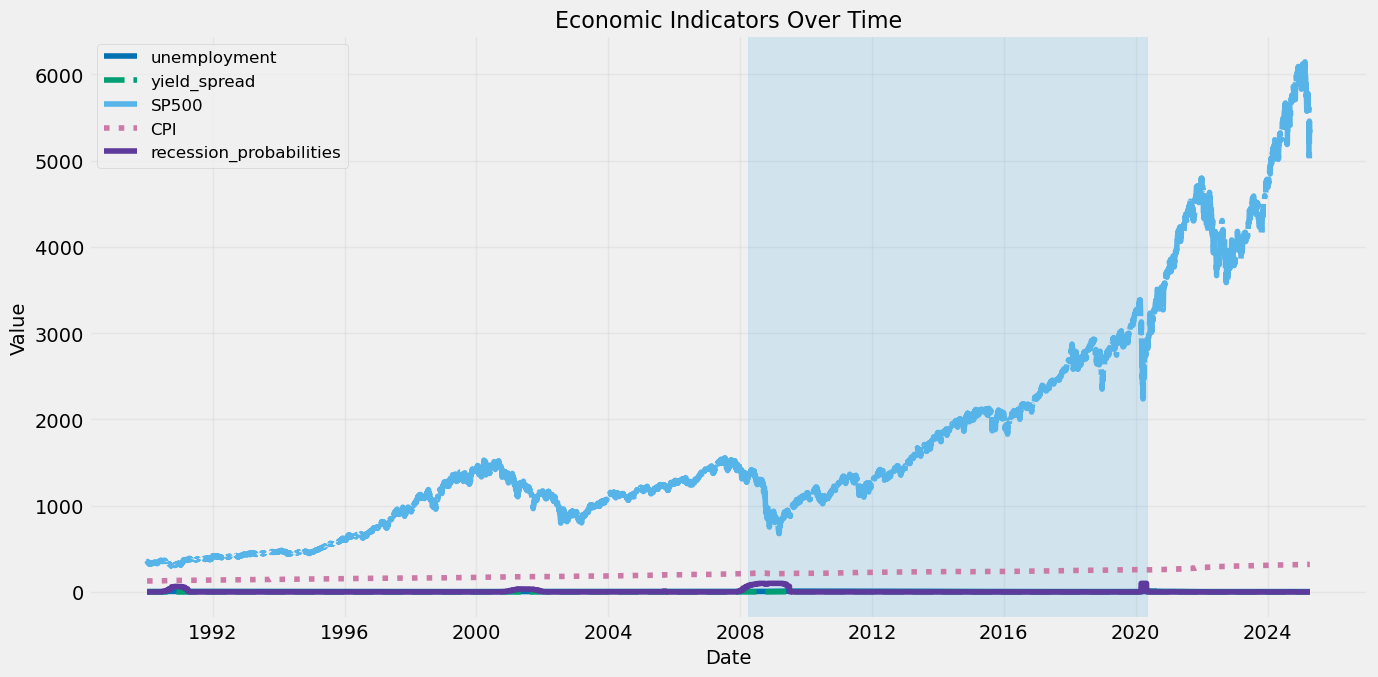

In [13]:
# 1. Time Series Plot of Key Indicators
plt.figure(figsize=(14, 7))

# Define a colorblind-friendly palette manually (avoid red and yellow)
colorblind_palette = ['#0072B2', '#009E73', '#56B4E9', '#CC79A7', '#5D3A9B']
line_styles = ['-', '--', '-.', ':', '-']

# Plot each column with a unique color and line style
for i, col in enumerate(key_columns):
    plt.plot(combined_data.index, 
             combined_data[col], 
             label=col, 
             color=colorblind_palette[i % len(colorblind_palette)], 
             linestyle=line_styles[i % len(line_styles)])

plt.title('Economic Indicators Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add recession highlight periods with a blue shade instead of red
recession_periods = combined_data[combined_data['recession_probabilities'] > 70].index
if len(recession_periods) > 0:
    plt.axvspan(recession_periods.min(), recession_periods.max(), color='#56B4E9', alpha=0.2, label='High Recession Probability')

plt.savefig('./images/indicators_over_time.png', dpi=300)
plt.show();

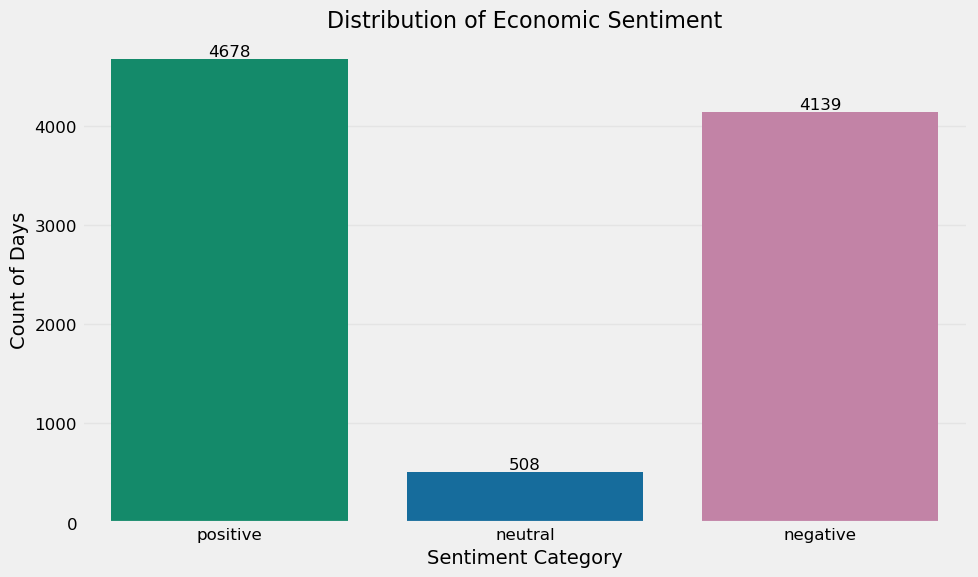

In [14]:
# 2. Sentiment Distribution with enhanced styling
plt.figure(figsize=(10, 6))

# Create colorblind-friendly palette for sentiment (avoiding red and yellow)
sentiment_palette = {'positive': '#009E73',  # Green-blue
                     'neutral': '#0072B2',   # Blue
                     'negative': '#CC79A7'}  # Purple-pink

# Fix the countplot to use hue parameter
ax = sns.countplot(x='sentiment', 
                  hue='sentiment',
                  data=combined_data, 
                  palette=sentiment_palette,
                  legend=False,
                  order=['positive', 'neutral', 'negative'])

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Economic Sentiment', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Count of Days', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('./images/sentiment_distribution.png', dpi=300)
plt.show();

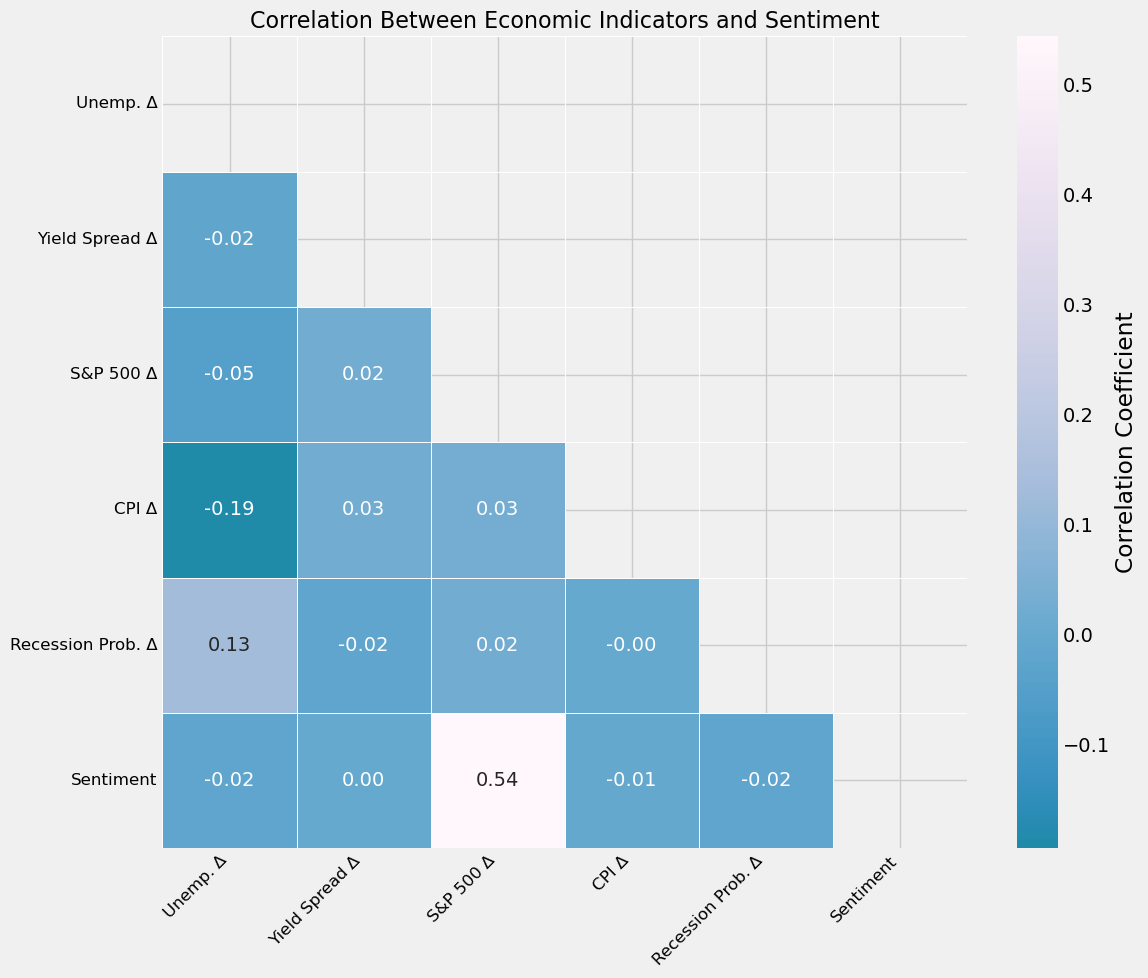

In [15]:
# 3. Correlation Heatmap with improved readability
# Encode sentiment numerically: positive=1, neutral=0, negative=-1
combined_data['sentiment_numeric'] = combined_data['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
numeric_features = features + ['sentiment_numeric']

# Create more readable correlation labels
label_map = {
    'unemployment_change': 'Unemp. Δ',
    'yield_spread_change': 'Yield Spread Δ',
    'SP500_change': 'S&P 500 Δ',
    'CPI_change': 'CPI Δ',
    'recession_probabilities_change': 'Recession Prob. Δ',
    'sentiment_numeric': 'Sentiment'
}

plt.figure(figsize=(12, 10))
correlation = combined_data[numeric_features].corr()

# Rename correlation columns/index
correlation = correlation.rename(columns=label_map, index=label_map)

# Create the heatmap with colorblind-friendly colormap
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, 
            annot=True, 
            cmap='PuBuGn_r',  # Colorblind-friendly purple-blue-green map
            linewidths=0.5,
            mask=mask,
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Between Economic Indicators and Sentiment', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig('./images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show();

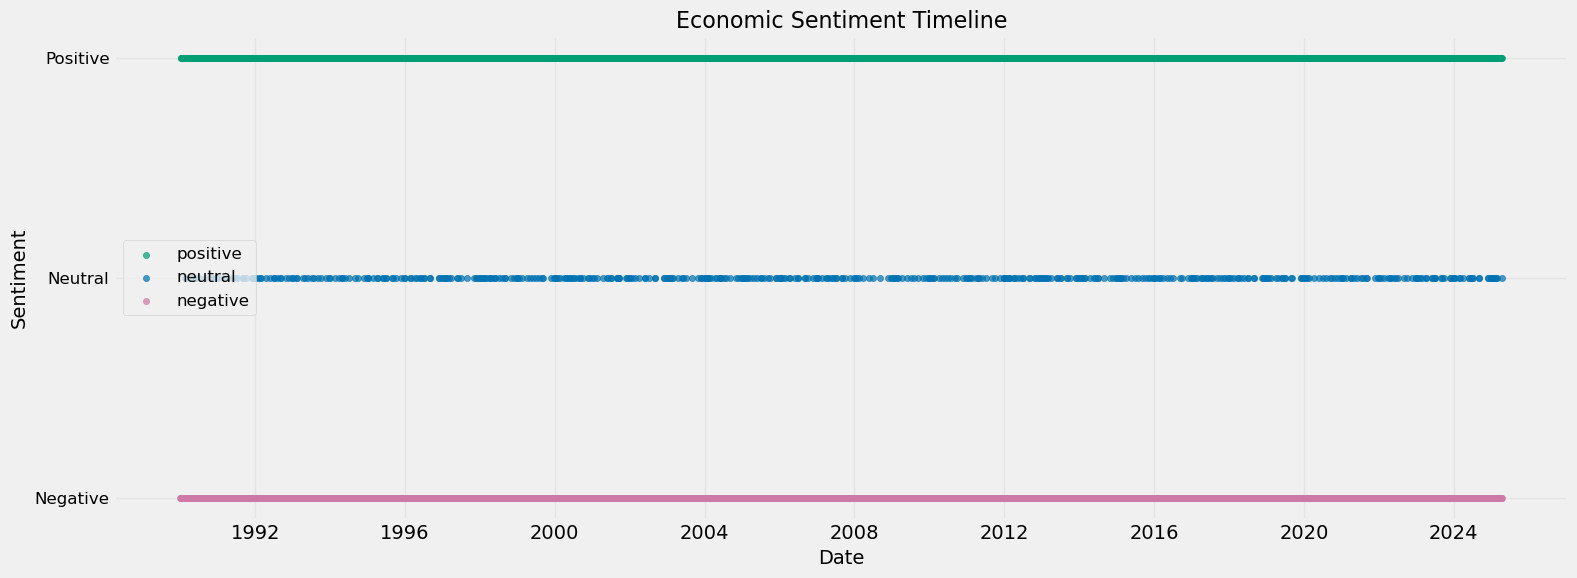

In [16]:
# 4. Sentiment over time visualization
plt.figure(figsize=(16, 6))

# Convert sentiment to numeric for plotting
# Using a colorblind-friendly palette (avoiding red and yellow)
sentiment_colors = {
    'positive': '#009E73',  # Green-blue
    'neutral': '#0072B2',   # Blue
    'negative': '#CC79A7'   # Purple-pink
}
combined_data['sentiment_value'] = combined_data['sentiment_numeric']

# Create multi-color scatter plot
for sentiment in sentiment_colors:
    mask = combined_data['sentiment'] == sentiment
    plt.scatter(combined_data.index[mask], 
                combined_data['sentiment_value'][mask],
                color=sentiment_colors[sentiment],
                alpha=0.7,
                s=20,
                label=sentiment)

plt.title('Economic Sentiment Timeline', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.yticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'], fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('./images/sentiment_timeline.png', dpi=300)
plt.show();

## 12. Advanced GPT Options and Future Improvements

Here are some better GPT tools and techniques that could improve our narrative generation:

### Recommended GPT Alternatives and Improvements

1. **Upgrade to GPT-3.5/GPT-4 via API**: These more advanced models produce much more coherent and contextually relevant economic narratives.
   - Example implementation code:
   ```python
   import openai
   
   def generate_narrative_gpt4(date, data, sentiment):
       # Format economic data as in our current function
       prompt = f"On {date_str}, economic indicators show..."  
       
       response = openai.ChatCompletion.create(
           model="gpt-4",
           messages=[
               {"role": "system", "content": "You are an economic analyst writing clear narratives for wealth managers of all skill levels."},
               {"role": "user", "content": prompt}
           ],
           max_tokens=150
       )
       
       return response['choices'][0]['message']['content']
   ```

2. **Fine-tune GPT-2 on Economic Reports**: Fine-tuning on a corpus of economic analyses and reports would greatly improve the quality and relevance of generated narratives.

## 13. Conclusion

This project successfully demonstrates how machine learning and natural language processing can transform complex economic data into accessible narratives for adult wealth managers of all skill levels. By combining sentiment classification with text generation, we provide interpretable insights that help individuals understand economic conditions without specialized knowledge.

The generated narratives clearly show how economic indicators like unemployment, S&P 500, and recession probabilities interact to create overall economic sentiment, empowering better financial decision-making. Visualizations complement these narratives by providing additional context and trends over time.

For future work, implementing more advanced language models like GPT-4 or fine-tuned domain-specific models would significantly enhance narrative quality and relevance.